# Build a Machine Learning Model

This notebook is intended to use Machine Learning to build a (binary) classification model that will predict whether a receiver will be a **success or a bust** in the NFL, based on its college and NFL combine data. The key objective is to then test this predictive model against the **2020 draft class** and to **establish a ranking of incoming receivers** (on their likeliness to be a success) for the teams' managers to use. Our goal is to improve the performance of our model by:
- doing features selection
- using multiple ML algorithms
- defining what a success / bust is. For recall, a success (respectively a bust) is a player where its aggregate receiving yards during the first 5 seasons in the NFL is above (below) a set threshold.
- vary the threshold to classify success vs bust

In [66]:
import Machine_Learning_Model
import importlib
importlib.reload(Machine_Learning_Model)
from Machine_Learning_Model import *

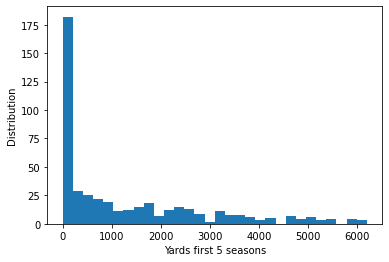

The data is zero-inflated... we build a classifier model rather than a linear regressor.
(463, 27)


In [34]:
tdcf = pd.read_csv('data_sets/tdcf.csv')

# drop rows that are both cfb and combine incomplete. List obtained from notebook 3)
tdcf = tdcf.drop(list_of_incomplete_rows, axis = 0).reset_index()

# Replacing an error in the scrapping about the draft age:
tdcf.loc[tdcf.combine_draft_age == 0,'combine_draft_age'] = np.nan

plt.hist(tdcf.rec_yards_ffs, bins = 30)
plt.xlabel('Yards first 5 seasons')
plt.ylabel('Distribution')
plt.show()
print('The data is zero-inflated... we build a classifier model rather than a linear regressor.')
print(tdcf.shape)

# 1) Features Selection, Preprocessing Data 

### Features Selection by Correlation Matrix

We've seen on the previous notebook that categorical data (conference and class) has massive impact on the target, which is why we'll do a features selection only on the numerical columns. We start with the Pearson's  Correlation Matrix

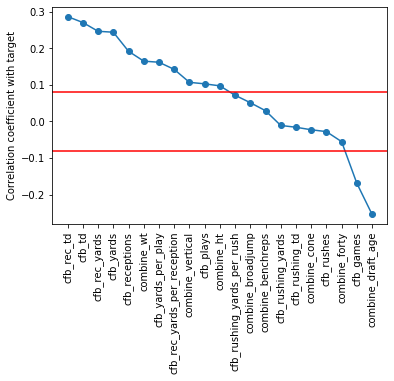

In [55]:
plt.plot(tdcf.corr(method='pearson').iloc[:-1,[-1]].sort_values(by = 'rec_yards_ffs', ascending = False),
        marker = 'o')
plt.xticks(rotation='vertical')
plt.axhline(y = 0.08, color = 'red')
plt.axhline(y = -0.08, color = 'red')
plt.ylabel('Correlation coefficient with target')
plt.show()

We notice many features land in the region where the correlation coefficient is less than 0.08 in absolute value. Let's do the same process with ExtraTreesClassifier from scikit-learn

### Tree-based Feature Importance: ExtraTreesClassifier

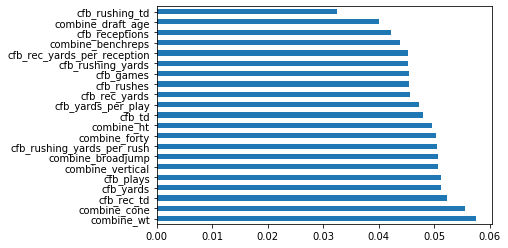

In [79]:
tdcfdna = tdcf.dropna()
X = tdcfdna.iloc[:,4:-1]
y = tdcfdna.iloc[:,-1]

model = ExtraTreesClassifier()
model.fit(X,y)

# plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending = False).plot(kind='barh')
plt.show()

From these analyses, we select the following features to run our model. We also avoid repetition of features, for example: cfb_td and cfb_rec_td, which respectively the aggregate number of TD's and the number of receiving TD's should be quite similar. We go with cfb_td in that case. Don't forget we also add the categorical features: cfb_conference and cfb_class

In [53]:
features_selected = ['cfb_td', 'cfb_yards', 'cfb_receptions','cfb_plays','cfb_yards_per_play',
'cfb_games','cfb_conference', 'cfb_class','combine_wt', 'combine_cone', 'combine_vertical',
'combine_broadjump','combine_forty', 'combine_draft_age']

df = tdcf[['rec_yards_ffs'] + features_selected]

In [4]:
df.head(3)

,rec_yards_ffs,cfb_td,cfb_yards,cfb_receptions,cfb_plays,cfb_yards_per_play,cfb_games,cfb_conference,cfb_class,combine_wt,combine_cone,combine_vertical,combine_broadjump,combine_forty,combine_draft_age
0,3571.0,28.0,3730.0,240.0,292.0,12.8,36.0,ACC,JR,211.0,6.95,34.0,126.0,4.43,21.0
1,6103.0,17.0,2499.0,151.0,151.0,16.5,26.0,SEC,SO,231.0,7.08,37.0,NaN,4.53,21.0
2,5476.0,12.0,2417.0,143.0,150.0,16.1,40.0,SEC,NaN,198.0,6.69,38.5,122.0,4.38,21.0


### Include Categorical Features

Convert the cfb_conference and cfb_class features to numerical data using pandas get_dummies
To avoid **multicolinearity issues**, we use the drop_first argument of the function

In [55]:
df = confclass_tonumerical(df)

# 2) Classification at fixed threshold: 200 yards

In this section, we fix the threshold at 200 yards. We then:
- preprocess the data by normalizing some features and dealing with categorical statistics by using pandas' get_dummies

Test the accuracy score of the following algorithms as a warmup.
- run a LogisticRegressor
- run KNeighborsClassifier
- run DecisionTrees
- run SVM
- run RandomForest

In [56]:
threshold = 200
df = success_function(df,'rec_yards_ffs',threshold)
df.success.value_counts(dropna = False)

1    283
0    180
Name: success, dtype: int64

### Transform our Data

- Set our features X and target y

- Fill in missing values with the 'mean' strategy and normalize only the numerical features: Xp


In [6]:
X = df.drop('success', axis = 1)
y = df.success

Xp = transformingX(X, 'mean', preprocessing.MinMaxScaler)

### Logistic Regression on a random train/test split data

In [453]:
# define the classifier, split the data, fit the classifier to the training data
logreg = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(Xp, y, test_size = .30, stratify = y, random_state = 42)
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
print('The accuracy score is', logreg.score(X_test, y_test))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

The accuracy score is 0.6906474820143885
[[30 24]
 [19 66]]
              precision    recall  f1-score   support

           0       0.61      0.56      0.58        54
           1       0.73      0.78      0.75        85

    accuracy                           0.69       139
   macro avg       0.67      0.67      0.67       139
weighted avg       0.69      0.69      0.69       139



**ROC Curve on the same random train/test split data: TPR and FPR**

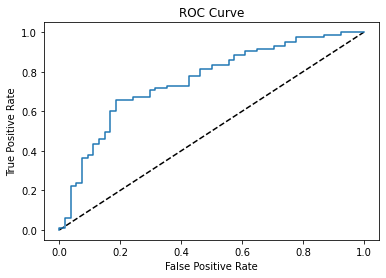

The AUC score is: 0.7553376906318082
The Log Loss is: 0.5728982331198691


In [454]:
# the probability estimates the predicted target is a success
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('The AUC score is:',roc_auc_score(y_test, y_pred_prob))
print('The Log Loss is:',log_loss(y_test, y_pred_prob))

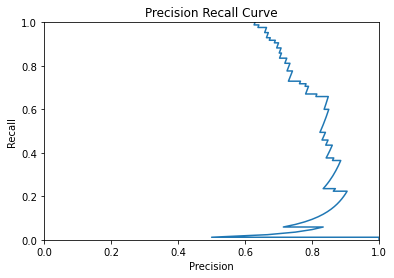

In [455]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(precision, recall)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision Recall Curve')
plt.show()

**From now, we'll do cross-validation with the rest of the algorithms**

In [51]:
logreg = LogisticRegression()
cv_scores = cross_validate(logreg, Xp, y, cv = 5)

print('Using a cross validation test on a 5-fold sample, the average score returned is',np.mean(cv_scores['test_score']))

Using a cross validation test on a 5-fold sample, the average score returned is 0.6715988779803647


### KNeighborsClassifier

In [57]:
knn = KNeighborsClassifier(n_neighbors = 3)
cv_scores = cross_validate(knn, Xp, y, cv = 5)

print('Using a cross validation test on a 5-fold sample, the average score returned is',np.mean(cv_scores['test_score']))

Using a cross validation test on a 5-fold sample, the average score returned is 0.6240532959326788


### SVM

In [61]:
svm = SVC(kernel = 'linear')
cv_scores = cross_validate(svm, Xp, y, cv = 5)

print('Using a cross validation test on a 5-fold sample, the average score returned is',np.mean(cv_scores['test_score']))

Using a cross validation test on a 5-fold sample, the average score returned is 0.6543010752688172


### Decision Trees

In [65]:
tr = DecisionTreeClassifier()
cv_scores = cross_validate(tr, Xp, y, cv = 5)

print('Using a cross validation test on a 5-fold sample, the average score returned is',np.mean(cv_scores['test_score']))

Using a cross validation test on a 5-fold sample, the average score returned is 0.6093267882187938


### Random Forest

In [66]:
forest = RandomForestClassifier()
cv_scores = cross_validate(forest, Xp, y, cv = 5)

print('Using a cross validation test on a 5-fold sample, the average score returned is',np.mean(cv_scores['test_score']))

Using a cross validation test on a 5-fold sample, the average score returned is 0.680411407199626


# 3) Via a Pipeline

**Transform the Data**

In [343]:
# Set our features X and target y
X = df.drop('success', axis = 1)
y = df.success

# Fill in missing values with the 'mean' strategy and normalize only the numerical features: Xp
Xp = transformingX(X, 'mean', preprocessing.MinMaxScaler)

We try **multiple classifers** and use a **parameter grid** to vary some of the fundament parameters of each model 

In [223]:
pipeline = Pipeline([ ('classifier' , RandomForestClassifier()) ])

param_grid = [
    {'classifier': [LogisticRegression()],
    'classifier__C' : np.logspace(-5, 5, 11),
     'classifier__penalty' : ['l1', 'l2'],
     'classifier__solver' : ['liblinear']},
    {'classifier': [KNeighborsClassifier()],
     'classifier__n_neighbors': np.arange(1,15)},
    {'classifier': [SVC()],
     'classifier__C': np.logspace(-5, 5, 11),
     'classifier__kernel':['linear', 'poly']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : np.arange(10,101,10),
    'classifier__max_features' : np.arange(1,11,2),
    'classifier__min_samples_leaf':[25]}
    ]


clf = GridSearchCV(pipeline, param_grid, 
                   scoring = 'f1', 
                   cv = 5)

Fit the **GridSearchCV object** against the training data, using a **5-fold cross validation**

In [226]:
X_train, X_test, y_train, y_test = train_test_split(Xp, y, test_size = .30, random_state = 42)
clf.fit(X_train, y_train)

In [234]:
print(clf.best_params_)
print('The best score is', clf.best_score_)

{'classifier': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=25, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), 'classifier__max_features': 5, 'classifier__min_samples_leaf': 25, 'classifier__n_estimators': 10}
The best score is 0.7950407298794395


While the above statement returns the best model, its best parameters and the score, we look to test how it does against the whole training set at once. In particular, we derive the confusion matrix and the classification report of a few performance metrics

In [233]:
y_pred = clf.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

[[ 58  62]
 [ 18 186]]
              precision    recall  f1-score   support

           0       0.76      0.48      0.59       120
           1       0.75      0.91      0.82       204

    accuracy                           0.75       324
   macro avg       0.76      0.70      0.71       324
weighted avg       0.75      0.75      0.74       324



# 4) Classification with varying threshold

In [34]:
# GridSearchCV using Logistic Regressor (C - value) and Penalty

# param_grid = {'C': np.logspace(-5, 8, 15),'penalty': ['l1', 'l2']}
# logreg = LogisticRegression()
# logreg_cv = GridSearchCV(logreg, param_grid, cv=5, verbose=0)
# logreg_cv.fit(X, y)
# print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
# print("Best score is {}".format(logreg_cv.best_score_))
# print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
# print('Best C:', best_model.best_estimator_.get_params()['C'])

# GridSearchCV using KNeighbors (knn)

# param_grid = {'n_neighbors':np.arange(1, 50)}
# knn = KNeighborsClassifier()
# knn_cv = GridSearchCV(knn, param_grid, cv = 10)
# knn_cv.fit(X, y)
# print(knn_cv.best_params_)
# print(knn_cv.best_score_)


# GridSearchCV using KNeighbors (knn) but for VARYING threshold

# param_grid = {'n_neighbors':np.arange(1,30)}
# knn = KNeighborsClassifier()
# knn_cv = GridSearchCV(knn, param_grid, cv = 10)

# bp_list=[]
# bs_list=[]
# for thresh in np.arange(1,100,5):
#     y = wr2.yffs
#     y = splitter(y, thresh)
#     knn_cv.fit(X, y)
#     bp_list.append(knn_cv.best_params_)
#     bs_list.append(knn_cv.best_score_)

For thresholds varying between 1 and 200, we perform a GridSearch Cross Validation over 10 folds on the ridge regressor, which aims to return the best score of the predictive model and the best alpha parameter each time. The reason why we aim for 10 folds is because we want eventually test our model against a unique year in the draft, which we represent 10% of our data.

We store the results for flop-data and success-data in two lists, which we display below

# 5) Testing on the Class of 2020

### Import data

We import the data for the class of 2020 and label it **X_test**. Everything is done so that the test data is formated identically to the training data

In [57]:
from Collecting_Data_TableDraft_Functions import *

url_draft_2020 = 'https://www.pro-football-reference.com/play-index/draft-finder.cgi?request=1&year_min=2020&year_max=2020&pick_type=overall&pos%5B%5D=wr&conference=any&show=all&order_by=default'
# scrapt draft table to get cfb data
table_draft_2020 = draft_nfl_cfb_scrap(url_draft_2020)
table_draft_2020.to_csv('data_sets/2020/table_draft_2020.csv', index=False)

/Users/adriensaremi/anaconda3/lib/python3.7/site-packages/pandas/core/internals/blocks.py:903: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


In [240]:
from Collecting_Data_TableCombine_and_Cleaning import *

combine_table = pd.read_csv('data_sets/combine_data_since_2000.csv')

# merge and search for combine data
draft_2020 = merge_combine(table_draft_2020, combine_table)
draft_2020 = search_combine(draft_2020)

# remove useless features and rename one of the columns 
draft_2020 = draft_2020[list_of_columns_selected]
draft_2020 = draft_2020.rename(columns=rename_column)

# pick the same features as df
draft_2020 = draft_2020[features_selected]
draft_2020.loc[21,'cfb_class'] = np.nan

#draft_2020.to_csv('data_sets/draft_2020_features.csv', index=False)

In [58]:
table_draft_2020 = pd.read_csv('data_sets/2020/table_draft_2020.csv')
draft_2020 = pd.read_csv('data_sets/2020/draft_2020_features.csv')

### Transform the 2020 Data and the Training Data

We transform both training and 2020 data the same way, so that the columns of our two dataframes match and the classifier works identically against both.

In [59]:
# Transform training data using 'mean' strategy for missing values and normalize the numerical columns
X = df.drop('success', axis = 1)
y = df.success
Xp = transformingX(X, 'mean', preprocessing.MinMaxScaler)
X_train, X_test, y_train, y_test = train_test_split(Xp, y, test_size = .30, stratify = y, random_state = 42)

# Transform draft_2020 the same way
draft_2020 = confclass_tonumerical_2(draft_2020)
draft_2020p = transformingX(draft_2020, 'mean', preprocessing.MinMaxScaler)

### Building the model from 'train' and test its performance from 'test'

Before testing the RandomForestClassifier against the 2020 draft, let's first find its performance against the testing data. For recall, the classifier was trained against the **f1-score metric**

In [60]:
# Classifier
forest = RandomForestClassifier(max_features = 5, n_estimators = 10, min_samples_leaf=25, random_state = 42)

# Fit to train data
forest.fit(X_train, y_train)

# Performance against testing data
y_pred = forest.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

[[ 41  85]
 [ 11 187]]
              precision    recall  f1-score   support

           0       0.79      0.33      0.46       126
           1       0.69      0.94      0.80       198

    accuracy                           0.70       324
   macro avg       0.74      0.63      0.63       324
weighted avg       0.73      0.70      0.67       324



### Predict and predict_proba the 2020 draft

We now predict:
- which players of the draft will be success (or busts): pred_2020
- the probability the players will be a success. This allows to perform a ranking of these players.

In [61]:
pred_2020 = forest.predict(draft_2020p)
pred_2020_prob = forest.predict_proba(draft_2020p)[:,1]

In [63]:
df_2020_pred = table_draft_2020[['player','round','pick','draft_team','college']]
df_2020_pred = df_2020_pred.assign(chance_of_success = pred_2020_prob)

**The draft, as it happened IRL**

In [64]:
display(df_2020_pred)

,player,round,pick,draft_team,college,chance_of_success
0,Henry Ruggs III,1,12,LVR,Alabama,0.641087
1,Jerry Jeudy,1,15,DEN,Alabama,0.698984
2,CeeDee Lamb,1,17,DAL,Oklahoma,0.673304
3,Jalen Reagor,1,21,PHI,TCU,0.666908
4,Justin Jefferson,1,22,MIN,LSU,0.702758
5,Brandon Aiyuk,1,25,SFO,Arizona St.,0.594505
6,Tee Higgins,2,33,CIN,Clemson,0.766833
7,Michael Pittman Jr.,2,34,IND,USC,0.629874
8,Laviska Shenault Jr.,2,42,JAX,Colorado,0.659533
9,KJ Hamler,2,46,DEN,Penn St.,0.601496


**And the draft, as it would have happened based on our model**

In [65]:
df_2020_pred.sort_values(by = 'chance_of_success', ascending=False)

,player,round,pick,draft_team,college,chance_of_success
6,Tee Higgins,2,33,CIN,Clemson,0.766833
12,Denzel Mims,2,59,NYJ,Baylor,0.759888
4,Justin Jefferson,1,22,MIN,LSU,0.702758
1,Jerry Jeudy,1,15,DEN,Alabama,0.698984
16,Gabriel Davis,4,128,BUF,Central Florida,0.694840
23,Isaiah Coulter,5,171,HOU,Rhode Island,0.674755
2,CeeDee Lamb,1,17,DAL,Oklahoma,0.673304
27,Quez Watkins,6,200,PHI,Southern Miss,0.667332
3,Jalen Reagor,1,21,PHI,TCU,0.666908
17,Antonio Gandy-Golden,4,142,WAS,Liberty,0.662541
